In [1]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

3.10.9


In [2]:
# Generate some chemical data:

bond_lengths = [1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

mol_list = ["1p8","2p0","2p2","2p4","2p6","2p8","3p0"]


py"""

mol_list = ["1p8","2p0","2p2","2p4","2p6","2p8","3p0"]
#mol_list = ["2p2"]

for m in range(len(mol_list)):
    config = configparser.ConfigParser()
    config.read(wd+'/../configs/h2o-double-dissoc/'+mol_list[m]+'.ini')
    RunPySCF.RunPySCF(config)

"""

True
converged SCF energy = -74.5112961651925
converged SCF energy = -74.5112961687029
True
SCF not converged.
SCF energy = -74.4011088560926
converged SCF energy = -74.4012364583999
True
SCF not converged.
SCF energy = -74.3304026518781
converged SCF energy = -74.3304107372596
True
converged SCF energy = -74.296332155923
converged SCF energy = -74.2963321563073
True
converged SCF energy = -74.2801471740171
converged SCF energy = -74.2801471741899
True
converged SCF energy = -74.2708005566972
converged SCF energy = -74.2708005568112
True
converged SCF energy = -74.2648615190109
converged SCF energy = -74.2648615216377


In [3]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

bond_lengths = [1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

mol_list = ["1p8","2p0","2p2","2p4","2p6","2p8","3p0"]

md_list = [
    "h2o_1p8A_sto-3g_051523%120846.hdf5",
    "h2o_2p0A_sto-3g_051523%120847.hdf5",
    "h2o_2p2A_sto-3g_051523%120847.hdf5",
    "h2o_2p4A_sto-3g_051523%120848.hdf5",
    "h2o_2p6A_sto-3g_051523%120849.hdf5",
    "h2o_2p8A_sto-3g_051523%120850.hdf5",
    "h2o_3p0A_sto-3g_051523%120850.hdf5"
]

chemical_data_list = []

for (m,mol) in enumerate(md_list)

    cdata_list = ReadIn("../datasets/pyscf_data/"*mol);
    push!(chemical_data_list, cdata_list[1])
    PrintChemData(chemical_data_list[m])
    
end

Molecule name: h2o_1p8A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h2o_double_dissoc/1p8.xyz
RHF energy: -74.51129616870286
FCI energy: -74.79063381243292
Molecule name: h2o_2p0A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h2o_double_dissoc/2p0.xyz
RHF energy: -74.40123645839914
FCI energy: -74.76201009070279
Molecule name: h2o_2p2A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h2o_double_dissoc/2p2.xyz
RHF energy: -74.33041073725963
FCI energy: -74.7482939259097
Molecule name: h2o_2p4A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h2o_double_dissoc/2p4.xyz
RHF energy: -74.29633215630672
FCI energy: -74.74206585024643
Molecule name: h2o_2p6A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h2o_double_dissoc/2p6.xyz
RHF energy: -74.28014717414132
FCI energy: -74.73939426185474
Molecule name: h2o_2p8A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h2o_double_dissoc/2p8.xyz
RHF energy: -74.27080055680932
FCI en

In [2]:
# Standardized sweep objects:
opt_sweeps20 = Sweeps(40)
maxdim!(opt_sweeps20,20)
mindim!(opt_sweeps20,20)
cutoff!(opt_sweeps20,1e-12)
setnoise!(opt_sweeps20, 1e-3,1e-3,1e-3,1e-4,1e-4,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-6,1e-7)

opt_sweeps8 = Sweeps(40)
maxdim!(opt_sweeps8,8)
mindim!(opt_sweeps8,8)
cutoff!(opt_sweeps8,1e-12)
setnoise!(opt_sweeps8, 1e-3,1e-3,1e-3,1e-4,1e-4,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-6,1e-7)

opt_sweeps3 = Sweeps(40)
maxdim!(opt_sweeps3,3)
mindim!(opt_sweeps3,3)
cutoff!(opt_sweeps3,1e-12)
setnoise!(opt_sweeps3, 1e-3,1e-3,1e-3,1e-4,1e-4,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-6,1e-7)

noisy_sweeps3 = Sweeps(10)
maxdim!(noisy_sweeps3,3)
mindim!(noisy_sweeps3,3)
cutoff!(noisy_sweeps3,1e-12)
setnoise!(noisy_sweeps3, 1e-3)

# Geometry optimization parameters:
gp0 = GeomParameters(
    maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=1e1
)

op01 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-10,
    delta=[1e-2],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=1.0-1e-6
);

op02 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-10,
    delta=[1e-3],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=1.0-1e-6
);

op03 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-10,
    delta=[1e-4],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=1.0-1e-6
);


op1 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-10,
    delta=[0.0],
    ttol=0.1,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=1.0-1e-6
);

delta=[0.0,0.0,0.0]
noise=[1e-1,1e-1,1e-3];

In [3]:
gp0

GeomParameters
  maxiter: Int64 300000
  afunc: String "stun"
  a_alpha: Float64 10.0
  a_gamma: Float64 100.0
  swap_mult: Float64 3.0
  a_tpow: Float64 5.0
  cweight: Float64 1.0
  eta: Int64 -2
  shrp: Float64 2.0
  anchor: Int64 0
  return_all: Bool false


In [4]:
op1

OptimParameters
  maxiter: Int64 1
  numloop: Int64 1
  numopt: Int64 -1
  noise: Array{Float64}((1,)) [0.0]
  delta: Array{Float64}((1,)) [0.0]
  theta: Float64 0.0
  ttol: Float64 0.1
  thresh: String "inversion"
  eps: Float64 1.0e-8
  sd_method: String "triple_geneig"
  sd_thresh: String "inversion"
  sd_eps: Float64 1.0e-10
  sd_penalty: Float64 0.999999
  sd_dtol: Float64 0.0001


In [5]:
using ConfParser

fid = h5open("../datasets/tnqe_data/h2o_test_2023-05-19.h5", "r")

conf_path = read(fid["conf_path"])

conf, op_list, gp_list, swp_list = FetchConfig("../$(conf_path)")

op_list[1]

OptimParameters
  maxiter: Int64 1
  numloop: Int64 1
  numopt: Int64 -1
  noise: Array{Float64}((1,)) [0.0]
  delta: Array{Float64}((1,)) [0.0]
  theta: Float64 0.0
  ttol: Float64 0.1
  thresh: String "inversion"
  eps: Float64 1.0e-8
  sd_method: String "triple_geneig"
  sd_thresh: String "inversion"
  sd_eps: Float64 1.0e-10
  sd_penalty: Float64 0.999999
  sd_dtol: Float64 0.0001


In [6]:
gp_list[1]

GeomParameters
  maxiter: Int64 300000
  afunc: String "stun"
  a_alpha: Float64 10.0
  a_gamma: Float64 100.0
  swap_mult: Float64 3.0
  a_tpow: Float64 5.0
  cweight: Float64 1.0
  eta: Int64 -2
  shrp: Float64 2.0
  anchor: Int64 0
  return_all: Bool false


In [12]:
close(fid)

In [5]:
# Collect the various estimates:

e_dmrg8_vec = []
e_dmrg3_vec = []
e_nomps_vec = []
e_tnqe_vec = []
Ipq_vec = []

# Repeat for each geometry:
for m=1:length(mol_list)
    
    cdata = chemical_data_list[m]
    
    println("\n\n##### MOLECULAR GEOMETRY $(m)/$(length(mol_list)): #####\n\n")
    
    # FCI-MPS object for determining bipartition entropies:
    fci_mps, ham_mpo = FCIMPS(cdata, verbose=true);
    S1, S2, Ipq = MutualInformation(fci_mps, collect(1:cdata.N_spt), cdata)
    
    push!(Ipq_vec, Ipq)
    
    opt_ord = InfDistAnnealing(
        Ipq, 
        1, 
        gp0,
        verbose=false
    )[1]
    
    println("\n\n##### DMRG m=8 #####\n")
    # DMRG with bond dimension 8:
    dmrg8 = GenSubspace(cdata, 1, psi_maxdim=8)
    dmrg8.ord_list = [opt_ord]
    
    GenPermOps!(dmrg8, verbose=true)
    GenStates!(dmrg8, sweeps=opt_sweeps8, verbose=true)
    GenSubspaceMats!(dmrg8, verbose=true)
    
    push!(e_dmrg8_vec, dmrg8.H_mat[1,1]+cdata.e_nuc)
    println(e_dmrg8_vec[end])
    
    
    println("\n\n##### DMRG m=3 #####\n")
    # DMRG with bond dimension 3:
    dmrg3 = GenSubspace(cdata, 1, psi_maxdim=3)
    dmrg3.ord_list = [opt_ord]
    
    GenPermOps!(dmrg3, verbose=true)
    GenStates!(dmrg3, sweeps=opt_sweeps3, verbose=true)
    GenSubspaceMats!(dmrg3, verbose=true)
    
    push!(e_dmrg3_vec, dmrg3.H_mat[1,1]+cdata.e_nuc)
    println(e_dmrg3_vec[end])
    
    
    println("\n\n##### NOMPS m=3 #####\n")
    # NOMPS with 5 states, bond dimension 3:
    nomps = GenSubspace(cdata, 5, psi_maxdim=3)
    nomps.ord_list = [opt_ord for j=1:nomps.mparams.M]
    
    GenPermOps!(nomps, verbose=true)
    GenHams!(nomps)
    GenStates!(nomps, randomize=true, verbose=true)
    """
    for j=nomps.mparams.M:nomps.mparams.M
        _, nomps.psi_list[j] = dmrg(nomps.ham_list[j], nomps.psi_list[j], noisy_sweeps3, outputlevel=0)
    end
    """
    GenSubspaceMats!(nomps, verbose=true)
    SolveGenEig!(nomps, thresh="inversion", eps=1e-8, verbose=false)
    
    # Optimize:
    for k=1:2
        
        SeedNoise!(
            nomps,
            delta[k],
            noise[k]
        )
        
        TwoSitePairSweep!(
            nomps,
            op1,
            #jpairs=[[1,2],[2,3],[3,4],[4,5],[1,5]],
            verbose=true
        )
        
    end

    OneSitePairSweep!(
        nomps,
        op1,
        #jpairs=[[1,2],[2,3],[3,4],[4,5],[1,5]],
        verbose=true
    )
    
    push!(e_nomps_vec, nomps.E[1]+cdata.e_nuc)
    println(e_nomps_vec[end])
    
    println("\n\n##### TNQE m=3 #####\n")
    # TNQE with 5 states, bond dimension 3:
    tnqe1 = GenSubspace(cdata, 5, psi_maxdim=3)
    #tnqe1.ord_list = [randperm(tnqe1.chem_data.N_spt) for j=1:tnqe1.mparams.M]
    #tnqe1.ord_list[end] = opt_ord
    
    tnqe1.ord_list = InfDistAnnealing(
        Ipq, 
        tnqe1.mparams.M, 
        gp0,
        #ord_list=tnqe1.ord_list,
        #anchors=[tnqe1.mparams.M],
        verbose=false
    )
    
    GenPermOps!(tnqe1, verbose=true)
    GenHams!(tnqe1)
    GenStates!(tnqe1, randomize=true, verbose=true)
    """
    for j=tnqe1.mparams.M:tnqe1.mparams.M
        _, tnqe1.psi_list[j] = dmrg(tnqe1.ham_list[j], tnqe1.psi_list[j], noisy_sweeps3, outputlevel=0)
    end
    """
    GenSubspaceMats!(tnqe1, verbose=true)
    SolveGenEig!(tnqe1, thresh="inversion", eps=1e-8, verbose=false)

    # Optimize:
    for k=1:2
        
        SeedNoise!(
            tnqe1,
            delta[k],
            noise[k]
        )
        
        TwoSitePairSweep!(
            tnqe1,
            op1,
            #jpairs=[[1,2],[2,3],[3,4],[4,5],[1,5]],
            verbose=true
        )
        
    end

    OneSitePairSweep!(
        tnqe1,
        op1,
        #jpairs=[[1,2],[2,3],[3,4],[4,5],[1,5]],
        verbose=true
    )
    
    push!(e_tnqe_vec, tnqe1.E[1]+cdata.e_nuc)
    println(e_tnqe_vec[end])
    
end



##### MOLECULAR GEOMETRY 1/7: #####


Computing FCI MPS:
Progress: 97400/97461  
-74.7906338125301
Done!


##### DMRG m=8 #####

Generating permutation operators:

Done!

Generating states:
Progress: [1/1] 
Done!
-74.79040619905703


##### DMRG m=3 #####

Generating permutation operators:

Done!

Generating states:
Progress: [1/1] 
Done!
-74.67963119026004


##### NOMPS m=3 #####

Generating permutation operators:
Progress: [10/10] 
Done!

Generating states:
Progress: [5/5] 
Done!

TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 10/10; sweep: 1/1; bond: 6/6; E_min = -79.68017; kappa = 4.99     
Done!


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 10/10; sweep: 1/1; bond: 6/6; E_min = -79.68021; kappa = 6.61     
Done!


TWO-STATE, ONE-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 10/10; sweep: 1/1; site: 7/7; E_min = -79.68026; kappa = 6.58     
Done!

-74.79008739241222


##### TNQE m=3 #####

Generating permutation operators:
Progress: [10/10] 
Done!

Generating states:
Pro

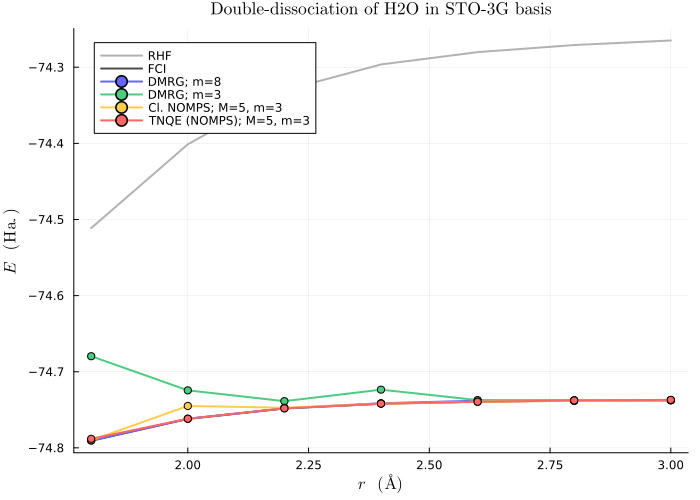

In [6]:
e_rhf_vec = [chemical_data_list[m].e_rhf for m=1:length(chemical_data_list)]
e_fci_vec = [chemical_data_list[m].e_fci for m=1:length(chemical_data_list)]

using LaTeXStrings

plot(
    bond_lengths, 
    e_rhf_vec, 
    color=RGB(0.7,0.7,0.7), 
    linewidth=2.0,
    label="RHF",
    title="Double-dissociation of H2O in STO-3G basis",
    titlefontsize=11.0,
    titlefont=font(14,"Computer Modern"),
    xguide=L"r\quad(\AA)",
    yguide=L"E\quad(\textrm{Ha.})",
    size=(700,500)
)

plot!(
    bond_lengths, 
    e_fci_vec, 
    color=RGB(0.3,0.3,0.3), 
    linewidth=2.0,
    label="FCI"
)


plot!(
    bond_lengths, 
    e_dmrg8_vec, 
    color=RGB(0.4,0.4,1.0), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="DMRG; m=8"
)

plot!(
    bond_lengths, 
    e_dmrg3_vec, 
    color=RGB(0.3,0.8,0.5), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="DMRG; m=3"
)

plot!(
    bond_lengths, 
    e_nomps_vec, 
    color=color=RGB(1.0,0.8,0.3), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="Cl. NOMPS; M=5, m=3"
)

plot!(
    bond_lengths, 
    e_tnqe_vec, 
    color=color=RGB(1.0,0.4,0.4), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="TNQE (NOMPS); M=5, m=3"
)

#savefig("../plots/H2O_DoubleDissoc/RHF-to-FCI_comparison.svg")

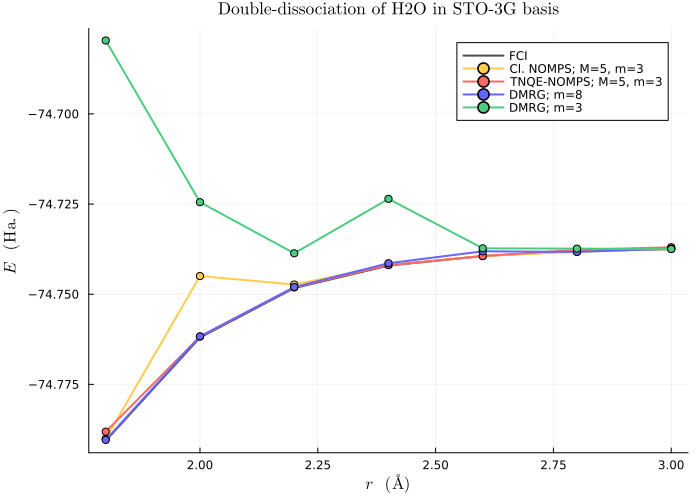

In [7]:
plot(
    bond_lengths, 
    e_fci_vec, 
    color=RGB(0.3,0.3,0.3), 
    linewidth=2.0,
    label="FCI",
    title="Double-dissociation of H2O in STO-3G basis",
    titlefontsize=11.0,
    titlefont=font(14,"Computer Modern"),
    xguide=L"r\quad(\AA)",
    yguide=L"E\quad(\textrm{Ha.})",
    size=(700,500)
)

plot!(
    bond_lengths, 
    e_nomps_vec, 
    color=color=RGB(1.0,0.8,0.3), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="Cl. NOMPS; M=5, m=3"
)

plot!(
    bond_lengths, 
    e_tnqe_vec, 
    color=color=RGB(1.0,0.4,0.4), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="TNQE-NOMPS; M=5, m=3"
)

plot!(
    bond_lengths, 
    e_dmrg8_vec, 
    color=RGB(0.4,0.4,1.0), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="DMRG; m=8"
)

plot!(
    bond_lengths, 
    e_dmrg3_vec, 
    color=RGB(0.3,0.8,0.5), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="DMRG; m=3"
)

#savefig("../plots/H2O_DoubleDissoc/FCI-All_comparison.svg")

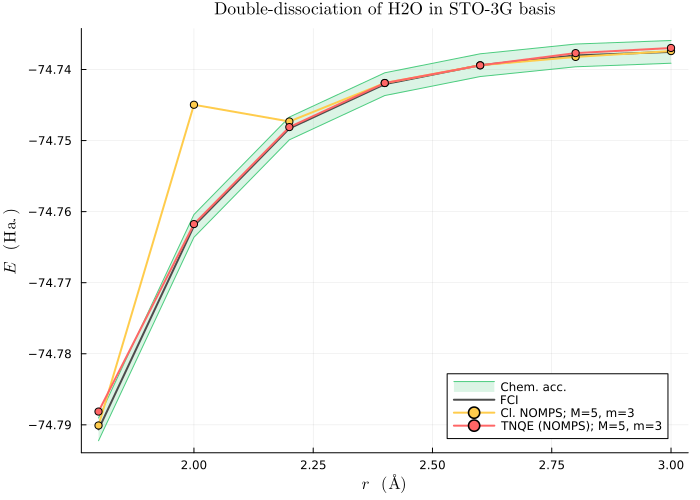

In [8]:
plot(
    bond_lengths,
    e_fci_vec.+0.0016,
    fillrange = e_fci_vec.-0.0016,
    color = RGB(0.3,0.8,0.5),
    fillalpha = 0.2,
    label = "Chem. acc.",
    title="Double-dissociation of H2O in STO-3G basis",
    titlefontsize=11.0,
    titlefont=font(14,"Computer Modern"),
    xguide=L"r\quad(\AA)",
    yguide=L"E\quad(\textrm{Ha.})",
    size=(700,500)
)

plot!(
    bond_lengths,
    e_fci_vec.-0.0016,
    color = RGB(0.3,0.8,0.5),
    primary=false
)

plot!(
    bond_lengths, 
    e_fci_vec, 
    color=RGB(0.3,0.3,0.3), 
    linewidth=2.0,
    label="FCI"
)

plot!(
    bond_lengths, 
    e_nomps_vec, 
    color=color=RGB(1.0,0.8,0.3), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="Cl. NOMPS; M=5, m=3"
)

plot!(
    bond_lengths, 
    e_tnqe_vec, 
    color=color=RGB(1.0,0.4,0.4), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="TNQE (NOMPS); M=5, m=3"
)

#savefig("../plots/H2O_DoubleDissoc/ChemAcc_comparison.svg")

In [8]:
"""
plot!(
    bond_lengths, 
    e_dmrg8_vec, 
    color=RGB(0.4,0.4,1.0), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="DMRG; m=8"
)
"""

"plot!(\n    bond_lengths, \n    e_dmrg8_vec, \n    color=RGB(0.4,0.4,1.0), \n    linewidth=2.0,\n    markersize=4,\n    markershape=:circle,\n    label=\"DMRG; m=8\"\n)\n"

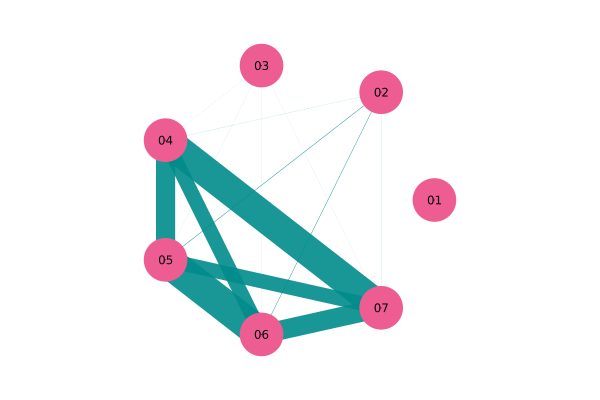

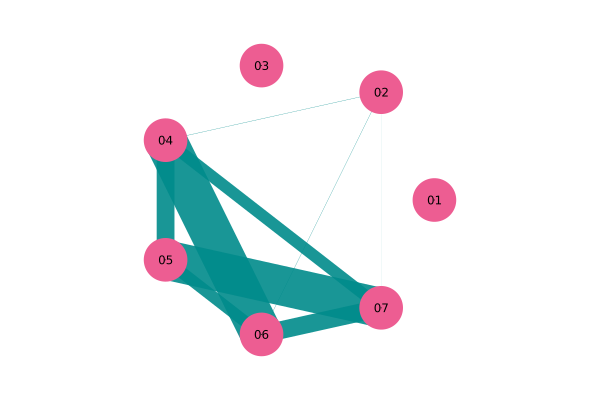

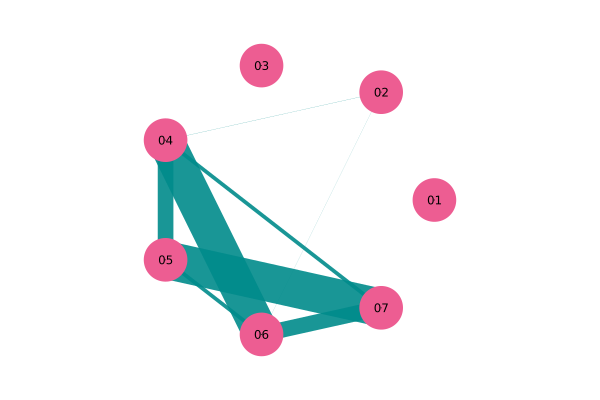

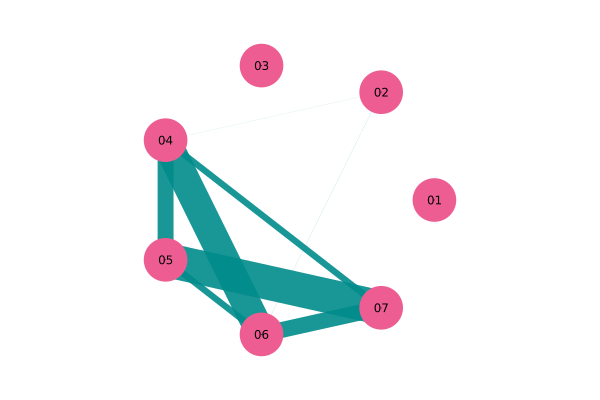

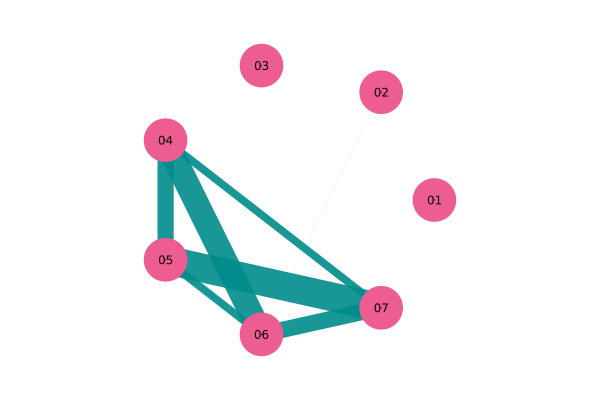

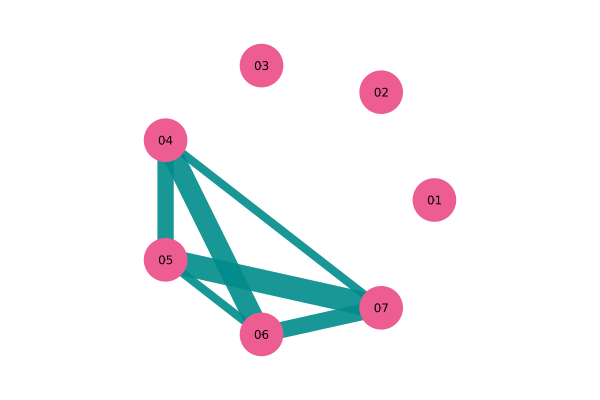

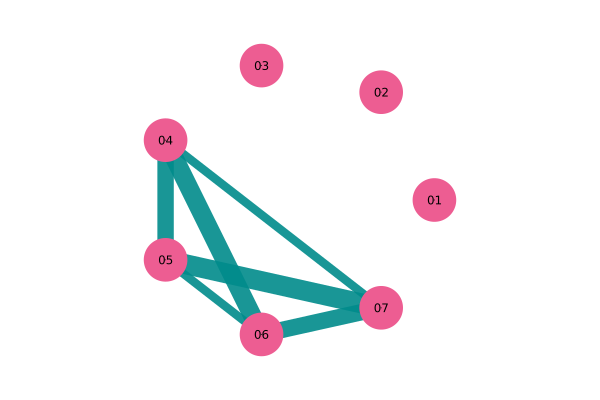

In [9]:
for (m, Ipq) in enumerate(Ipq_vec)
    
    OrbitalGraphPlot(Ipq, multiplier=3e1)
    
    savefig("../plots/H2O_DoubleDissoc/MutualInformation/r=$(bond_lengths[m]).svg")
    
end

In [46]:
println([1,2][2])

2


In [15]:
vec = [1,3,2,4,5]

5-element Vector{Int64}:
 1
 3
 2
 4
 5

In [17]:
findall(x->x==3, vec)[1]

2